<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/main/C4/W4/ungraded_labs/C4_W4_Lab_2_Sunspots_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

kaggle project: Sunspot prediction.
Use deep neural network to forecast sunspot.

Dataset from : a monthly record of sunspot numbers from January 1749 to July 2018.
(https://www.kaggle.com/datasets/robervalt/sunspots) 

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

/Users/jingyiliu/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Plotting visualization set up.

In [2]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      label (string) - tag for the line
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 4))

    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

# Load data set.

In [4]:
# Download the dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv

--2024-07-28 16:59:47--  https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.68.91, 142.250.68.59, 142.250.217.155, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.68.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [text/csv]
Saving to: ‘Sunspots.csv’

Sunspots.csv        100%[===================>]  69.17K  --.-KB/s    in 0.01s   

2024-07-28 16:59:47 (7.07 MB/s) - ‘Sunspots.csv’ saved [70827/70827]



In [5]:
# Preview the dataset
!head Sunspots.csv

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7
5,1749-06-30,139.2
6,1749-07-31,158.0
7,1749-08-31,110.5
8,1749-09-30,126.5


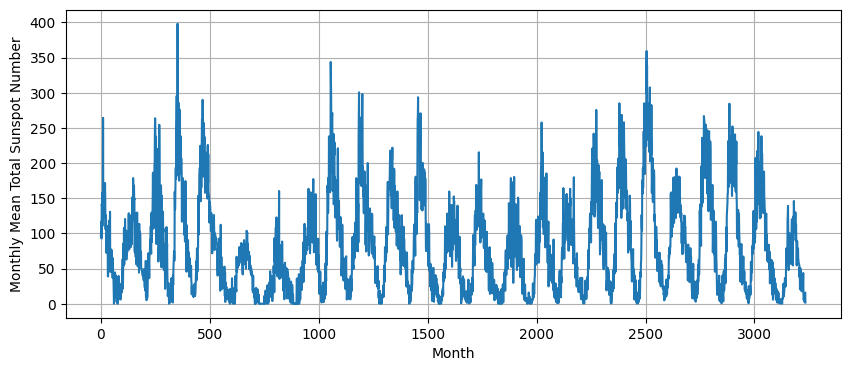

In [6]:
# Initialize lists
time_step = []
sunspots = []

# Open CSV file
with open('./Sunspots.csv') as csvfile:

  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')

  # Skip the first line
  next(reader)

  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    sunspots.append(float(row[2]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(sunspots)

# Preview the data
plot_series(time, series, xlabel='Month', ylabel='Monthly Mean Total Sunspot Number')

# Split the Dataset

Split the dataset into training and validation sets. There are 3235 points in the dataset and the first 3000 data is for training.

In [7]:
# Define the split time
split_time = 3000

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

# Prepare Features and Labels

The window size is set to 30 points (equal to 2.5 years).

In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [10]:
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# Model set up

The model will be 3-layer dense network.

In [11]:
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Print the model summary
model.summary()

/Users/jingyiliu/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,251 (4.89 KB)

 Trainable params: 1,251 (4.89 KB)

 Non-trainable params: 0 (0.00 B)

Tune the Learning Rate

In [12]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 138.5521 - learning_rate: 1.0000e-08
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 139.6926 - learning_rate: 1.1220e-08
Epoch 3/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 137.0196

2024-07-28 17:08:10.554928: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/contextlib.py:135: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(type, value, traceback)
2024-07-28 17:08:10.746761: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 135.6627 - learning_rate: 1.2589e-08
Epoch 4/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 127.5672   

2024-07-28 17:08:10.898358: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 134.0831 - learning_rate: 1.4125e-08
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 132.3103 - learning_rate: 1.5849e-08
Epoch 6/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 111.0801

2024-07-28 17:08:11.223425: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:08:11.366997: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 127.2668 - learning_rate: 1.7783e-08
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 126.0990 - learning_rate: 1.9953e-08
Epoch 8/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 127.2908

2024-07-28 17:08:11.514721: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:08:11.662409: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 123.3389 - learning_rate: 2.2387e-08
Epoch 9/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 120.6274 - learning_rate: 2.5119e-08
Epoch 10/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 115.7122

2024-07-28 17:08:11.808439: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:08:11.955396: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 113.1920 - learning_rate: 2.8184e-08
Epoch 11/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 110.1934 - learning_rate: 3.1623e-08
Epoch 12/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 87.4595

2024-07-28 17:08:12.105077: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:08:12.251195: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 104.1507 - learning_rate: 3.5481e-08
Epoch 13/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 103.3019 - learning_rate: 3.9811e-08
Epoch 14/100


2024-07-28 17:08:12.397634: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:08:12.543964: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 97.0732 - learning_rate: 4.4668e-08
Epoch 15/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 94.6247 - learning_rate: 5.0119e-08
Epoch 16/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 105.3946

2024-07-28 17:08:12.692686: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:08:12.838025: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 90.7705 - learning_rate: 5.6234e-08
Epoch 17/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 87.3366 - learning_rate: 6.3096e-08
Epoch 18/100


2024-07-28 17:08:12.984104: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:08:13.130314: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 83.3212 - learning_rate: 7.0795e-08
Epoch 19/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 81.9329 - learning_rate: 7.9433e-08
Epoch 20/100


2024-07-28 17:08:13.286724: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:08:13.453117: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 77.2632 - learning_rate: 8.9125e-08
Epoch 21/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 75.7213 - learning_rate: 1.0000e-07
Epoch 22/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 65.4585

2024-07-28 17:08:13.601218: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:08:13.747629: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 72.6989 - learning_rate: 1.1220e-07
Epoch 23/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 67.9383 - learning_rate: 1.2589e-07
Epoch 24/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 66.6268

2024-07-28 17:08:13.896076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:08:14.041640: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 65.6798 - learning_rate: 1.4125e-07
Epoch 25/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 62.8843 - learning_rate: 1.5849e-07
Epoch 26/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 63.2726

2024-07-28 17:08:14.188642: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:08:14.334806: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 58.5225 - learning_rate: 1.7783e-07
Epoch 27/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 54.0549 - learning_rate: 1.9953e-07
Epoch 28/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 43.6940

2024-07-28 17:08:14.482317: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:08:14.627543: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 48.5124 - learning_rate: 2.2387e-07
Epoch 29/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 43.9651 - learning_rate: 2.5119e-07
Epoch 30/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 22.7097

2024-07-28 17:08:14.775264: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:08:14.919960: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 39.7061 - learning_rate: 2.8184e-07
Epoch 31/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 36.9870 - learning_rate: 3.1623e-07
Epoch 32/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 26.2864

2024-07-28 17:08:15.068865: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:08:15.213466: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 34.6162 - learning_rate: 3.5481e-07
Epoch 33/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 33.8306 - learning_rate: 3.9811e-07
Epoch 34/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 24.6563

2024-07-28 17:08:15.360424: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:08:15.503664: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 32.5774 - learning_rate: 4.4668e-07
Epoch 35/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - loss: 31.7708 - learning_rate: 5.0119e-07
Epoch 36/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 28.0159

2024-07-28 17:08:15.653615: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:08:15.797564: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 31.7656 - learning_rate: 5.6234e-07
Epoch 37/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 30.4063 - learning_rate: 6.3096e-07
Epoch 38/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 32.4680

2024-07-28 17:08:15.969365: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:08:16.113778: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 30.4116 - learning_rate: 7.0795e-07
Epoch 39/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 28.2670 - learning_rate: 7.9433e-07
Epoch 40/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 23.1519

2024-07-28 17:08:16.261400: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:08:16.406691: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 27.9156 - learning_rate: 8.9125e-07
Epoch 41/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - loss: 26.8381 - learning_rate: 1.0000e-06
Epoch 42/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 31.0417

2024-07-28 17:08:16.553535: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:08:16.697116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 26.8144 - learning_rate: 1.1220e-06
Epoch 43/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 26.1276 - learning_rate: 1.2589e-06
Epoch 44/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 24.3304

2024-07-28 17:08:16.846032: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:08:16.989554: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 24.8667 - learning_rate: 1.4125e-06
Epoch 45/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 24.8490 - learning_rate: 1.5849e-06
Epoch 46/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 13.8176

2024-07-28 17:08:17.137614: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:08:17.283739: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 24.0777 - learning_rate: 1.7783e-06
Epoch 47/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 23.9847 - learning_rate: 1.9953e-06
Epoch 48/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 24.3580

2024-07-28 17:08:17.429591: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:08:17.573199: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 23.6943 - learning_rate: 2.2387e-06
Epoch 49/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 22.4604 - learning_rate: 2.5119e-06
Epoch 50/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 13.7089

2024-07-28 17:08:17.719816: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:08:17.866294: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21.6868 - learning_rate: 2.8184e-06
Epoch 51/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 22.0252 - learning_rate: 3.1623e-06
Epoch 52/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 18.8995

2024-07-28 17:08:18.012781: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:08:18.158465: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21.4727 - learning_rate: 3.5481e-06
Epoch 53/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20.8943 - learning_rate: 3.9811e-06
Epoch 54/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 20.0871

2024-07-28 17:08:18.304447: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:08:18.449917: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20.3089 - learning_rate: 4.4668e-06
Epoch 55/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20.3921 - learning_rate: 5.0119e-06
Epoch 56/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 22.5180

2024-07-28 17:08:18.620841: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:08:18.765307: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19.7845 - learning_rate: 5.6234e-06
Epoch 57/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - loss: 19.8354 - learning_rate: 6.3096e-06
Epoch 58/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 17.2630

2024-07-28 17:08:18.910509: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:08:19.053863: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.9407 - learning_rate: 7.0795e-06
Epoch 59/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.5536 - learning_rate: 7.9433e-06
Epoch 60/100


2024-07-28 17:08:19.200841: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:08:19.357986: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.6354 - learning_rate: 8.9125e-06
Epoch 61/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - loss: 19.0782 - learning_rate: 1.0000e-05
Epoch 62/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 13.2271

2024-07-28 17:08:19.503872: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:08:19.647138: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.3662 - learning_rate: 1.1220e-05
Epoch 63/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.1341 - learning_rate: 1.2589e-05
Epoch 64/100


2024-07-28 17:08:19.794203: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:08:19.947866: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.0803 - learning_rate: 1.4125e-05
Epoch 65/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - loss: 18.7499 - learning_rate: 1.5849e-05
Epoch 66/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 17.0647

2024-07-28 17:08:20.092741: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:08:20.235226: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.4476 - learning_rate: 1.7783e-05
Epoch 67/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.9279 - learning_rate: 1.9953e-05
Epoch 68/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 18.6759

2024-07-28 17:08:20.381549: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:08:20.526529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.8227 - learning_rate: 2.2387e-05
Epoch 69/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.8549 - learning_rate: 2.5119e-05
Epoch 70/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 17.0288

2024-07-28 17:08:20.670743: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:08:20.815472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.0457 - learning_rate: 2.8184e-05
Epoch 71/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19.3801 - learning_rate: 3.1623e-05
Epoch 72/100


2024-07-28 17:08:20.968407: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:08:21.137381: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.2835 - learning_rate: 3.5481e-05
Epoch 73/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.6634 - learning_rate: 3.9811e-05
Epoch 74/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 13.8512

2024-07-28 17:08:21.289207: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:08:21.434413: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.4757 - learning_rate: 4.4668e-05
Epoch 75/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.5740 - learning_rate: 5.0119e-05
Epoch 76/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 12.4487

2024-07-28 17:08:21.579506: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:08:21.728003: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.4467 - learning_rate: 5.6234e-05
Epoch 77/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.6401 - learning_rate: 6.3096e-05
Epoch 78/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 16.4458

2024-07-28 17:08:21.874815: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:08:22.019414: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.0906 - learning_rate: 7.0795e-05
Epoch 79/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - loss: 16.9689 - learning_rate: 7.9433e-05
Epoch 80/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 14.5175

2024-07-28 17:08:22.165484: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:08:22.307597: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.8054 - learning_rate: 8.9125e-05
Epoch 81/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.2734 - learning_rate: 1.0000e-04
Epoch 82/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 16.1414

2024-07-28 17:08:22.453612: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:08:22.598462: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19.3506 - learning_rate: 1.1220e-04
Epoch 83/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - loss: 17.5298 - learning_rate: 1.2589e-04
Epoch 84/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 21.0378

2024-07-28 17:08:22.742962: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:08:22.887169: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.5142 - learning_rate: 1.4125e-04
Epoch 85/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - loss: 17.5651 - learning_rate: 1.5849e-04
Epoch 86/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 11.9363

2024-07-28 17:08:23.035293: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:08:23.177855: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19.7544 - learning_rate: 1.7783e-04
Epoch 87/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19.1245 - learning_rate: 1.9953e-04
Epoch 88/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 19.0438

2024-07-28 17:08:23.322642: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:08:23.469575: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.5218 - learning_rate: 2.2387e-04
Epoch 89/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.6489 - learning_rate: 2.5119e-04
Epoch 90/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 19.3783

2024-07-28 17:08:23.639949: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:08:23.784708: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19.6486 - learning_rate: 2.8184e-04
Epoch 91/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20.2581 - learning_rate: 3.1623e-04
Epoch 92/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 15.4487

2024-07-28 17:08:23.931802: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:08:24.077877: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.6698 - learning_rate: 3.5481e-04
Epoch 93/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 20.1068 - learning_rate: 3.9811e-04
Epoch 94/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 17.2302

2024-07-28 17:08:24.222627: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:08:24.363837: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.0911 - learning_rate: 4.4668e-04
Epoch 95/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19.3022 - learning_rate: 5.0119e-04
Epoch 96/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 16.6164

2024-07-28 17:08:24.509547: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:08:24.653272: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 22.3057 - learning_rate: 5.6234e-04
Epoch 97/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 26.3330 - learning_rate: 6.3096e-04
Epoch 98/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 17.8202

2024-07-28 17:08:24.799433: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:08:24.944138: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 29.5739 - learning_rate: 7.0795e-04
Epoch 99/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 22.4001 - learning_rate: 7.9433e-04
Epoch 100/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 13.6435

2024-07-28 17:08:25.095610: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:08:25.242806: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21.0104 - learning_rate: 8.9125e-04


2024-07-28 17:08:25.387911: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


(1e-08, 0.001, 0.0, 100.0)

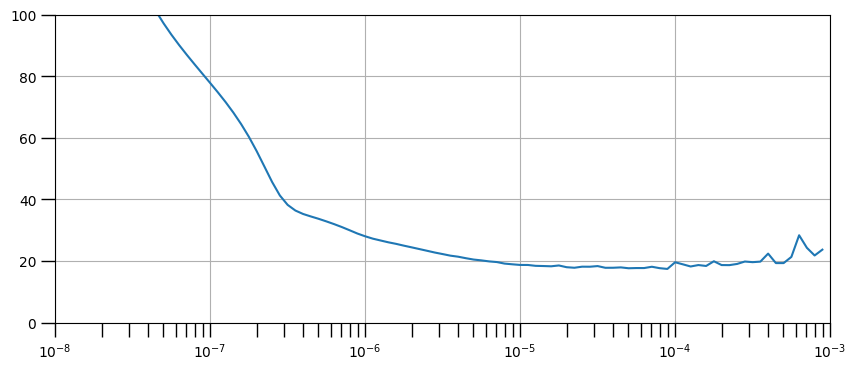

In [14]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 4))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

Picked a learning rate based on above results; rebuild the model and start training.

In [15]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [16]:
# Set the learning rate
learning_rate = 4e-5

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=100)

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 27.8670 - mae: 28.3616
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 22.1504 - mae: 22.6441
Epoch 3/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 12.1308 - mae: 12.6308

2024-07-28 17:09:41.469122: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/contextlib.py:135: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(type, value, traceback)
2024-07-28 17:09:41.615831: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19.0600 - mae: 19.5547
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - loss: 18.1240 - mae: 18.6155
Epoch 5/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 13.6116 - mae: 14.0963

2024-07-28 17:09:41.766886: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:09:41.911345: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.1090 - mae: 18.5983
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.9287 - mae: 18.4211
Epoch 7/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 15.3127 - mae: 15.8127

2024-07-28 17:09:42.061163: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:09:42.206489: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.8067 - mae: 18.2993
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - loss: 17.6570 - mae: 18.1472
Epoch 9/100


2024-07-28 17:09:42.355140: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:09:42.499548: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.4063 - mae: 17.8973
Epoch 10/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.3313 - mae: 17.8237
Epoch 11/100


2024-07-28 17:09:42.672893: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:09:42.820749: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.9186 - mae: 18.4096
Epoch 12/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.6574 - mae: 18.1457
Epoch 13/100


2024-07-28 17:09:42.969138: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:09:43.118060: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.2435 - mae: 17.7350
Epoch 14/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.5595 - mae: 18.0500
Epoch 15/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 16.5561 - mae: 17.0561

2024-07-28 17:09:43.264288: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:09:43.411585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.9525 - mae: 17.4458
Epoch 16/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.7650 - mae: 17.2572
Epoch 17/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 16.8229 - mae: 17.3093

2024-07-28 17:09:43.560458: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:09:43.707559: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.6071 - mae: 18.0968
Epoch 18/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.6730 - mae: 17.1623
Epoch 19/100


2024-07-28 17:09:43.855419: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:09:44.003977: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.1291 - mae: 16.6199
Epoch 20/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.8327 - mae: 17.3241
Epoch 21/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 17.7272 - mae: 18.2138

2024-07-28 17:09:44.151829: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:09:44.297708: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.6067 - mae: 17.0954
Epoch 22/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.7646 - mae: 17.2559
Epoch 23/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 18.4726 - mae: 18.9726

2024-07-28 17:09:44.444543: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:09:44.591141: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.7085 - mae: 18.2008
Epoch 24/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.8574 - mae: 17.3462
Epoch 25/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 15.1309 - mae: 15.6129

2024-07-28 17:09:44.737566: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:09:44.882043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.4702 - mae: 16.9577
Epoch 26/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - loss: 17.0947 - mae: 17.5858
Epoch 27/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 15.2689 - mae: 15.7580

2024-07-28 17:09:45.054487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:09:45.198491: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.3115 - mae: 17.8051
Epoch 28/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.2068 - mae: 17.6987
Epoch 29/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 14.3186 - mae: 14.7955

2024-07-28 17:09:45.345488: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:09:45.491186: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.5511 - mae: 17.0419
Epoch 30/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.4141 - mae: 16.9050
Epoch 31/100


2024-07-28 17:09:45.638187: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:09:45.784106: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.5179 - mae: 18.0077
Epoch 32/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.8600 - mae: 17.3515
Epoch 33/100


2024-07-28 17:09:45.943884: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:09:46.094592: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.7391 - mae: 17.2287
Epoch 34/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.2340 - mae: 16.7244
Epoch 35/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 14.5245 - mae: 15.0240

2024-07-28 17:09:46.241582: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:09:46.387653: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - loss: 16.3649 - mae: 16.8556
Epoch 36/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - loss: 16.9216 - mae: 17.4123
Epoch 37/100


2024-07-28 17:09:46.529076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:09:46.694024: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.0459 - mae: 17.5362
Epoch 38/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - loss: 16.3034 - mae: 16.7937
Epoch 39/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 13.8124 - mae: 14.2806

2024-07-28 17:09:46.840527: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:09:46.982506: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - loss: 16.5296 - mae: 17.0172
Epoch 40/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.6866 - mae: 17.1784
Epoch 41/100


2024-07-28 17:09:47.124439: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:09:47.276154: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.3902 - mae: 16.8813
Epoch 42/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.7570 - mae: 17.2477
Epoch 43/100


2024-07-28 17:09:47.441168: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:09:47.588177: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.1149 - mae: 16.6023
Epoch 44/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - loss: 16.4300 - mae: 16.9192
Epoch 45/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 18.2740 - mae: 18.7647

2024-07-28 17:09:47.737443: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:09:47.880662: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.3363 - mae: 17.8253
Epoch 46/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - loss: 16.2919 - mae: 16.7798
Epoch 47/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 13.4445 - mae: 13.9340

2024-07-28 17:09:48.032593: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:09:48.175113: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - loss: 16.4810 - mae: 16.9722
Epoch 48/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - loss: 16.0970 - mae: 16.5897
Epoch 49/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 13.2295 - mae: 13.7240

2024-07-28 17:09:48.316281: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:09:48.458231: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - loss: 16.1893 - mae: 16.6792
Epoch 50/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 16.4084 - mae: 16.9005
Epoch 51/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 15.9278 - mae: 16.4152

2024-07-28 17:09:48.600940: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:09:48.740905: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - loss: 17.0978 - mae: 17.5877
Epoch 52/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - loss: 17.0295 - mae: 17.5199
Epoch 53/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 22.0290 - mae: 22.5241

2024-07-28 17:09:48.882400: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:09:49.023656: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.8406 - mae: 17.3324
Epoch 54/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - loss: 16.1183 - mae: 16.6076
Epoch 55/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 14.2143 - mae: 14.6916

2024-07-28 17:09:49.164920: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:09:49.305917: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - loss: 16.5138 - mae: 17.0037
Epoch 56/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - loss: 16.3744 - mae: 16.8630
Epoch 57/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 18.2984 - mae: 18.7600

2024-07-28 17:09:49.447705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:09:49.587227: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.2796 - mae: 17.7691
Epoch 58/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - loss: 15.9118 - mae: 16.3997
Epoch 59/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 16.6568 - mae: 17.1563

2024-07-28 17:09:49.754489: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:09:49.896003: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - loss: 15.9614 - mae: 16.4535
Epoch 60/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 16.6349 - mae: 17.1237
Epoch 61/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 13.7183 - mae: 14.1943

2024-07-28 17:09:50.036855: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:09:50.176664: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - loss: 16.4897 - mae: 16.9781
Epoch 62/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - loss: 16.5665 - mae: 17.0544
Epoch 63/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 15.9630 - mae: 16.4456

2024-07-28 17:09:50.315372: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:09:50.457392: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.4954 - mae: 16.9850
Epoch 64/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - loss: 16.2239 - mae: 16.7142
Epoch 65/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 18.0218 - mae: 18.5218

2024-07-28 17:09:50.599127: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:09:50.738666: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - loss: 16.0915 - mae: 16.5822
Epoch 66/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - loss: 16.9072 - mae: 17.3956
Epoch 67/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 21.8462 - mae: 22.3375

2024-07-28 17:09:50.877183: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:09:51.016658: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - loss: 16.2694 - mae: 16.7582
Epoch 68/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - loss: 16.5019 - mae: 16.9903
Epoch 69/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 13.8535 - mae: 14.3275

2024-07-28 17:09:51.156118: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:09:51.296255: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - loss: 16.0924 - mae: 16.5821
Epoch 70/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - loss: 16.7108 - mae: 17.1997
Epoch 71/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 11.1421 - mae: 11.6412

2024-07-28 17:09:51.437119: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:09:51.575323: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - loss: 16.0944 - mae: 16.5822
Epoch 72/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - loss: 16.4568 - mae: 16.9477
Epoch 73/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 19.2017 - mae: 19.7017

2024-07-28 17:09:51.715332: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:09:51.855352: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - loss: 16.4395 - mae: 16.9289
Epoch 74/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 16.3235 - mae: 16.8122
Epoch 75/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 17.6835 - mae: 18.1685

2024-07-28 17:09:51.994719: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:09:52.133390: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - loss: 16.3656 - mae: 16.8544
Epoch 76/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - loss: 16.1188 - mae: 16.6060
Epoch 77/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 16.1673 - mae: 16.6572

2024-07-28 17:09:52.272179: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:09:52.410739: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - loss: 16.4605 - mae: 16.9486
Epoch 78/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - loss: 16.6231 - mae: 17.1133
Epoch 79/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 19.2161 - mae: 19.7019

2024-07-28 17:09:52.548199: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:09:52.686412: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - loss: 16.0889 - mae: 16.5782
Epoch 80/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - loss: 16.5038 - mae: 16.9932
Epoch 81/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 16.0743 - mae: 16.5552

2024-07-28 17:09:52.824523: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:09:52.963488: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - loss: 16.4978 - mae: 16.9857
Epoch 82/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - loss: 16.2161 - mae: 16.7056
Epoch 83/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 15.0206 - mae: 15.5195

2024-07-28 17:09:53.103383: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:09:53.241406: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - loss: 16.3087 - mae: 16.7993
Epoch 84/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - loss: 16.3810 - mae: 16.8688
Epoch 85/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 11.4307 - mae: 11.9283

2024-07-28 17:09:53.379279: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:09:53.516964: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - loss: 16.5178 - mae: 17.0085
Epoch 86/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 15.9317 - mae: 16.4226
Epoch 87/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 10.5118 - mae: 10.9900

2024-07-28 17:09:53.654575: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:09:53.791994: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - loss: 16.0022 - mae: 16.4895
Epoch 88/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - loss: 16.8648 - mae: 17.3567
Epoch 89/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 15.7648 - mae: 16.2609

2024-07-28 17:09:53.929294: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:09:54.068821: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - loss: 15.8360 - mae: 16.3275
Epoch 90/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - loss: 15.6910 - mae: 16.1811
Epoch 91/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 14.8771 - mae: 15.3674

2024-07-28 17:09:54.210287: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:09:54.348157: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - loss: 16.2159 - mae: 16.7074
Epoch 92/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - loss: 16.2812 - mae: 16.7703
Epoch 93/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 20.1839 - mae: 20.6777

2024-07-28 17:09:54.483986: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:09:54.623819: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - loss: 16.2353 - mae: 16.7248
Epoch 94/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 15.9893 - mae: 16.4809
Epoch 95/100


2024-07-28 17:09:54.762561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:09:54.922919: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - loss: 15.8354 - mae: 16.3255
Epoch 96/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - loss: 16.3389 - mae: 16.8298
Epoch 97/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 14.7032 - mae: 15.1722

2024-07-28 17:09:55.061983: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:09:55.200409: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - loss: 15.7537 - mae: 16.2419
Epoch 98/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 16.0773 - mae: 16.5670
Epoch 99/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 17.4334 - mae: 17.9334

2024-07-28 17:09:55.338011: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:09:55.475070: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - loss: 15.8765 - mae: 16.3675
Epoch 100/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - loss: 16.0832 - mae: 16.5732


2024-07-28 17:09:55.612251: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 17:09:55.748571: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


# Model Prediction

In [17]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


2024-07-28 17:10:29.273407: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


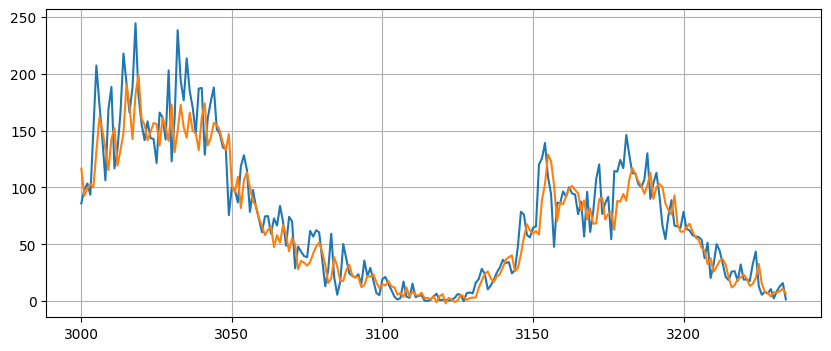

In [18]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [19]:
# Compute the MAE
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

15.398256
